In [1]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

In [2]:
# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [3]:
series.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64

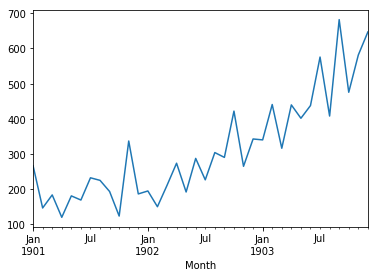

In [5]:
series.plot();

# Baseline LSTM Model

In [7]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from math import sqrt
import matplotlib
from matplotlib import pyplot
import numpy

In [8]:
matplotlib.use('Agg')

In [9]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

In [10]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

In [11]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [12]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [13]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [14]:
# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    # separate
    X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
    
    # reshape
    reshaped = X.reshape(len(X), 1, 1)
    
    # forecast dataset
    output = model.predict(reshaped, batch_size=batch_size)
    
    # invert data transforms on forecast
    predictions = list()
    
    for i in range(len(output)):
        yhat = output[i,0]
        # invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        # invert differencing
        yhat = yhat + raw_data[i]
        # store forecast
        predictions.append(yhat)
        
    # report performance
    rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
    
    # reset model state
    model.reset_states()
    
    return rmse

In [15]:
# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # prepare model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # fit model
    train_rmse, test_rmse = list(), list()
    
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
        
    history = DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    
    return history

In [16]:
# run diagnostic experiments
def run():
    # config
    n_lag = 1
    n_repeats = 10
    n_epochs = 1000
    n_batch = 4
    n_neurons = 3
    
    # load dataset
    series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    
    # run diagnostic tests
    for i in range(n_repeats):
        history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i+1, history['train'].iloc[-1], history['test'].iloc[-1]))
    pyplot.savefig('diagnostic_baseline.png')

1) TrainRMSE=56.173819, TestRMSE=105.607567
2) TrainRMSE=57.490814, TestRMSE=94.037456
3) TrainRMSE=58.225988, TestRMSE=100.319508
4) TrainRMSE=59.384857, TestRMSE=92.857189
5) TrainRMSE=59.002244, TestRMSE=93.570289
6) TrainRMSE=57.137133, TestRMSE=98.621218
7) TrainRMSE=57.366214, TestRMSE=96.427987
8) TrainRMSE=58.207542, TestRMSE=94.297583
9) TrainRMSE=57.760093, TestRMSE=96.435827
10) TrainRMSE=57.791868, TestRMSE=100.250391


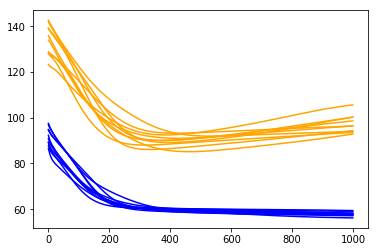

In [17]:
# entry point
run()

# Input Dropout

In [22]:
# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, dropout):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    
    for r in range(n_repeats):
        # fit the model
        train_trimmed = train_scaled[2:, :]
        lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons, dropout)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
        output = lstm_model.predict(test_reshaped, batch_size=n_batch)
        predictions = list()
        
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
            
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
        
    return error_scores

In [23]:
# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons, dropout):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # prepare model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, dropout=dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
        
    history = DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history

In [24]:
# run diagnostic experiments
def run():
    # config
    n_lag = 1
    n_repeats = 10
    n_epochs = 1000
    n_batch = 4
    n_neurons = 3
    dropout = 0.4
    # load dataset
    series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # run diagnostic tests
    for i in range(n_repeats):
        history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons, dropout)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i+1, history['train'].iloc[-1], history['test'].iloc[-1]))
        
    pyplot.savefig('diagnostic_dropout_input.png')

1) TrainRMSE=60.702509, TestRMSE=85.315646
2) TrainRMSE=61.314458, TestRMSE=87.336549
3) TrainRMSE=60.291312, TestRMSE=85.359807
4) TrainRMSE=60.711126, TestRMSE=88.947341
5) TrainRMSE=61.158097, TestRMSE=84.256617
6) TrainRMSE=59.674793, TestRMSE=90.906548
7) TrainRMSE=61.595836, TestRMSE=84.254624
8) TrainRMSE=60.575415, TestRMSE=89.889881
9) TrainRMSE=61.192704, TestRMSE=84.150880
10) TrainRMSE=60.860960, TestRMSE=81.292901


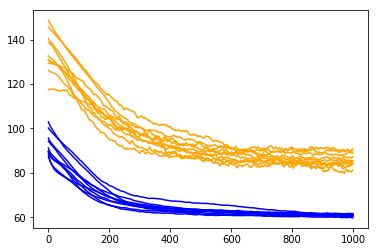

In [25]:
run()

# Recurrent Dropout

In [26]:
# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons, dropout):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # prepare model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, recurrent_dropout=dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
        
    history = DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history

In [27]:
# run diagnostic experiments
def run():
    # config
    n_lag = 1
    n_repeats = 10
    n_epochs = 1000
    n_batch = 4
    n_neurons = 3
    dropout = 0.4
    # load dataset
    series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # run diagnostic tests
    for i in range(n_repeats):
        history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons, dropout)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i+1, history['train'].iloc[-1], history['test'].iloc[-1]))
    pyplot.savefig('diagnostic_dropout_recurrent.png')

1) TrainRMSE=58.715748, TestRMSE=92.785545
2) TrainRMSE=58.615492, TestRMSE=94.584956
3) TrainRMSE=58.762132, TestRMSE=91.579802
4) TrainRMSE=60.101752, TestRMSE=89.253216
5) TrainRMSE=59.265697, TestRMSE=96.162944
6) TrainRMSE=55.499869, TestRMSE=90.617001
7) TrainRMSE=59.345262, TestRMSE=93.339682
8) TrainRMSE=59.138475, TestRMSE=91.167701
9) TrainRMSE=59.323632, TestRMSE=91.727282
10) TrainRMSE=59.466032, TestRMSE=94.489741


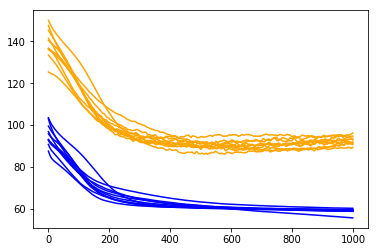

In [28]:
run()